


# Libraries

In [ ]:
# Install necessary libraries
!pip install -U -q transformers datasets peft accelerate bitsandbytes evaluate rouge_score

In [ ]:
# To ignore warnings
import warnings, re
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import T5ForQuestionAnswering,T5ForConditionalGeneration, T5Tokenizer, DataCollatorForSeq2Seq,pipeline,AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, BitsAndBytesConfig, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_dataset
import numpy as np
import nltk
import evaluate
import sys
import os
from peft import LoraConfig,get_peft_model,prepare_model_for_kbit_training,TaskType
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

2024-05-25 12:31:39.346680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 12:31:39.346796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 12:31:39.461012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [ ]:
# Load the dataset from Hugging Face
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
dataset = dataset['train']

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']
test_valid_split = temp_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset = test_valid_split['train']
test_dataset = test_valid_split['test']

In [ ]:
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Model and adapters configuration

In this section the goal is to fine-tune a T5 model with 61M of parameters using a T4 GPU. From traditional fine-tuning some issue arised due to VRAM limitations and output capacity of the used environment. This lead to the necessity of a **parameter-efficient fine-tuning** (PEFT) techniques like **LoRA** which employs 4-bit quantization.

**Quantization** is a technique used to reduce the number of bits that represent the model's weights and activations. The primary goal is to reduce the model's size and improve computational efficiency, especially on resource-constrained devices.


In [ ]:
# Configure BitsAndBytes for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant= False,
)

In [ ]:
# Load the base model and the tokenizer
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small",quantization_config=bnb_config, device_map="auto")
model.config.use_cache = False
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Configure LoRA parameters

lora_config = LoraConfig(
 r=16,
 lora_alpha=32,
 target_modules=["q", "v"],
 lora_dropout=0.05,
 bias="none",
 task_type=TaskType.SEQ_2_SEQ_LM
)

In [ ]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Integrate LoRA with the base model
model = get_peft_model(model, lora_config)

In [ ]:
# Print trainable parameters to verify configuration
model.print_trainable_parameters()

trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654


In [ ]:
# Load the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
prefix = "answer the question: "

def preprocess_function(examples):
    inputs = [prefix + question for question in examples["input"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    labels = tokenizer(text_target = examples["output"], max_length=512, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/3395 [00:00<?, ? examples/s]

Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

In [ ]:
# Set up Rouge score for evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [ ]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    num_train_epochs=10,
    predict_with_generate=True,
    push_to_hub=False
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.414000,0.367883,0.367843,0.250495,0.327986,0.332607
2,0.383700,0.356698,0.372550,0.255570,0.332414,0.336967
3,0.393300,0.350015,0.376252,0.259455,0.336865,0.341278
4,0.377900,0.345378,0.378078,0.263290,0.339440,0.343415
5,0.389200,0.342072,0.382109,0.268190,0.344486,0.348463
6,0.391400,0.339628,0.381324,0.265741,0.344137,0.348261
7,0.377900,0.337988,0.383235,0.269000,0.345822,0.349690
8,0.381100,0.336742,0.383765,0.268691,0.346805,0.350632
9,0.373400,0.335995,0.383756,0.269381,0.347605,0.351421
10,0.387200,0.335405,0.383710,0.269114,0.346829,0.350699


TrainOutput(global_step=90550, training_loss=0.3954801877725855, metrics={'train_runtime': 29793.1346, 'train_samples_per_second': 9.118, 'train_steps_per_second': 3.039, 'total_flos': 2598478609612800.0, 'train_loss': 0.3954801877725855, 'epoch': 10.0})

# Manual checking with random question from test dataset


In [ ]:
print(dataset['test'].data)

MemoryMappedTable
input: string
output: string
instruction: string
----
input: [["What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?","What leads to genitourinary syndrome of menopause (atrophic vaginitis)?","What does low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?","What are some possible causes of low PTH and high calcium levels?","How does the level of anti-müllerian hormone relate to ovarian reserve?",...,"What are the typical shapes of urine crystals found in uric acid kidney stones?","How can urine crystals found in uric acid kidney stones be described in terms of their shape?","What specific shapes do urine crystals take in uric acid kidney stones?","What type of paralysis may result from upper motoneuron lesions?","What is the relationship between upper motoneuron lesions and paralysis?"],["What effect do upper motoneuron lesions have on muscle tone?","How do upper motoneuron lesions affect muscle tone?","What is 

In [ ]:
df = dataset['test'].to_pandas()

In [ ]:
import random

for i in range(5):
    random_index = random.randint(0, len(df) - 1)
    random_row = df.iloc[random_index]
    prompt = random_row["input"] + " ->"
    actual_answer = random_row["output"]

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    response = model.generate(input_ids=input_ids, max_length=20)[0]

    response_text = tokenizer.decode(response, skip_special_tokens=True)

    print('*************************************')
    print('Question: ', prompt)
    print('Actual Answer:', actual_answer)
    print('Bot Answer: ', response_text)
    print('*************************************\n')

*************************************
Question:  At which phase of the cell cycle do Vincristine and Vinblastine act? ->
Actual Answer: Vincristine and Vinblastine act at the M phase of the cell cycle.
Bot Answer:  cell cycle
*************************************

*************************************
Question:  What is the recommended airway management technique for an unconscious patient with impaired respiratory status and suspected cervical fractures? ->
Actual Answer: The recommended airway management technique is rapid sequence intubation.

When a patient is unconscious and has impaired respiratory status, it is important to establish and maintain a patent airway in order to ensure adequate oxygenation and ventilation. However, in patients with suspected cervical fractures, airway management can be challenging due to the need to maintain cervical spine immobilization. Rapid sequence intubation (RSI) is a recommended airway management technique in these patients, as it allows for 

# Compute metrics

In this section some metrics are computed to compare generated answers to the original ones using cosine similarity and BLEU score:

*   **Cosine similarity** measures the similarity between reference and prediction embeddings
*   **BLEU score** measures the quality of text by comparing n-grams of the generated text with those of reference text.

Therefore, cosine similarity valuates similarity at the embedding level, focusing on the overall context and meaning represented by numerical vectors while bleu score evaluates the text accuracy at the token level, focusing on the precision of word sequences compared to reference texts.

In [ ]:
# Get answers from the dataset
test_data = dataset['test']
# Initialize the list for references
references = []

# Iterate over the test data and collect the first 500 'output' values
for index, row in enumerate(test_data):
    if index >= 500:
        break
    references.append(row['output'])

In [ ]:
def generate_answer(question):
    prompt = question + " ->"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    gen_output = model.generate(input_ids=input_ids, max_length=100)[0]
    response = tokenizer.decode(gen_output, skip_special_tokens=True)
    return response

total_questions = len(test_data)
predictions = []
count = 0

# Iterate over the test data and generate answers
for index, row in enumerate(test_data):
    if count >= 500:
        break
    print(f"Processed question {count + 1} out of {total_questions}")
    question = row["input"]
    predicted_answer = generate_answer(question)
    predictions.append(predicted_answer)
    count += 1

Processed question 1 out of 3396
Processed question 2 out of 3396
Processed question 3 out of 3396
Processed question 4 out of 3396
Processed question 5 out of 3396
Processed question 6 out of 3396
Processed question 7 out of 3396
Processed question 8 out of 3396
Processed question 9 out of 3396
Processed question 10 out of 3396
Processed question 11 out of 3396
Processed question 12 out of 3396
Processed question 13 out of 3396
Processed question 14 out of 3396
Processed question 15 out of 3396
Processed question 16 out of 3396
Processed question 17 out of 3396
Processed question 18 out of 3396
Processed question 19 out of 3396
Processed question 20 out of 3396
Processed question 21 out of 3396
Processed question 22 out of 3396
Processed question 23 out of 3396
Processed question 24 out of 3396
Processed question 25 out of 3396
Processed question 26 out of 3396
Processed question 27 out of 3396
Processed question 28 out of 3396
Processed question 29 out of 3396
Processed question 30 o

In [ ]:
# Function to calculate embeddings using the tokenizer
def calculate_embeddings(text_list):
    embeddings = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model.encoder(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())
    return embeddings

In [ ]:
# Calculate embeddings for references and predictions
reference_embeddings = calculate_embeddings(references)
prediction_embeddings = calculate_embeddings(predictions)

In [ ]:
# Compute cosine similarity for each pair of embeddings
cosine_similarities = []
for ref_emb, pred_emb in zip(reference_embeddings, prediction_embeddings):
    ref_emb = ref_emb.reshape(1, -1)
    pred_emb = pred_emb.reshape(1, -1)
    cos_sim = cosine_similarity(ref_emb, pred_emb)[0][0]
    cosine_similarities.append(cos_sim)

In [ ]:
# Calculate the average cosine similarity
average_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f'Average Cosine Similarity: {average_cosine_similarity:.2f}')

Average Cosine Similarity: 0.61


In [ ]:
# Function to calculate BLEU score
def calculate_bleu(reference, prediction):
    reference_tokens = [nltk.word_tokenize(reference)]
    prediction_tokens = nltk.word_tokenize(prediction)
    # Using smoothing function to avoid zero scores for short sequences
    smoothing_function = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smoothing_function)
    return bleu_score

In [ ]:
# Calculate BLEU scores for all predictions
bleu_scores = [calculate_bleu(ref, pred) for ref, pred in zip(references, predictions)]

In [ ]:
# Calculate average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score:.2f}')

Average BLEU Score: 0.02


# Performance on another dataset

In [ ]:
# Load the dataset from Hugging Face and converting into pandas to inspect it
data = load_dataset("GokulWork/QuestionAnswer_MCQ")
df = data['train'].to_pandas()
df.head(10)

,Unnamed: 0,question,answer,text
0,0,What is a force?,Correct Answer- A force is a push or pull that...,"###Human:\ngenerate a correct answer, a ration..."
1,1,What is Newton's First Law of Motion?,"Correct Answer- Newton's First Law of Motion, ...","###Human:\ngenerate a correct answer, a ration..."
2,2,What is the difference between speed and veloc...,Correct Answer- Speed is a scalar quantity tha...,"###Human:\ngenerate a correct answer, a ration..."
3,3,Explain that when the kinetic energy of an obj...,Correct Answer- The change in kinetic energy c...,"###Human:\ngenerate a correct answer, a ration..."
4,4,What is the SI unit of electric current?,Correct Answer- Ampere\n\nRationale- Ampere is...,"###Human:\ngenerate a correct answer, a ration..."
5,5,What does the term 'refraction' refer to in ph...,Correct Answer- Bending of light when it passe...,"###Human:\ngenerate a correct answer, a ration..."
6,6,What is the law of conservation of momentum?,Correct Answer- The total momentum of a closed...,"###Human:\ngenerate a correct answer, a ration..."
7,7,What is the primary role of a capacitor in an ...,Correct Answer- To store and release electric ...,"###Human:\ngenerate a correct answer, a ration..."
8,8,What is the result of applying a force to an o...,Correct Answer- Impulse.\n\nRationale- Impulse...,"###Human:\ngenerate a correct answer, a ration..."
9,9,What property of a wave determines its loudness?,Correct Answer- Amplitude.\n\nRationale- Ampli...,"###Human:\ngenerate a correct answer, a ration..."


In [ ]:
# Keeping only the Question-Answering pair and computing basic informations
dataframe = df[['question', 'answer']]
# Basic Information
print("Basic Information about the Dataset:")
print(f"Total Documents: {len(dataframe)}")
print(f"Average document length (words): {dataframe['question'].apply(lambda x: len(x.split())).mean()}")

Basic Information about the Dataset:
Total Documents: 205
Average document length (words): 12.61951219512195


In [ ]:
dataframe.head(5)

,question,answer
0,What is a force?,Correct Answer- A force is a push or pull that...
1,What is Newton's First Law of Motion?,"Correct Answer- Newton's First Law of Motion, ..."
2,What is the difference between speed and veloc...,Correct Answer- Speed is a scalar quantity tha...
3,Explain that when the kinetic energy of an obj...,Correct Answer- The change in kinetic energy c...
4,What is the SI unit of electric current?,Correct Answer- Ampere\n\nRationale- Ampere is...


In [ ]:
# TF-IDF Analysis
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_result = tfidf.fit_transform(dataframe['question'])
tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.columns = [str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
dataframe = pd.concat([dataframe, tfidf_df], axis=1)

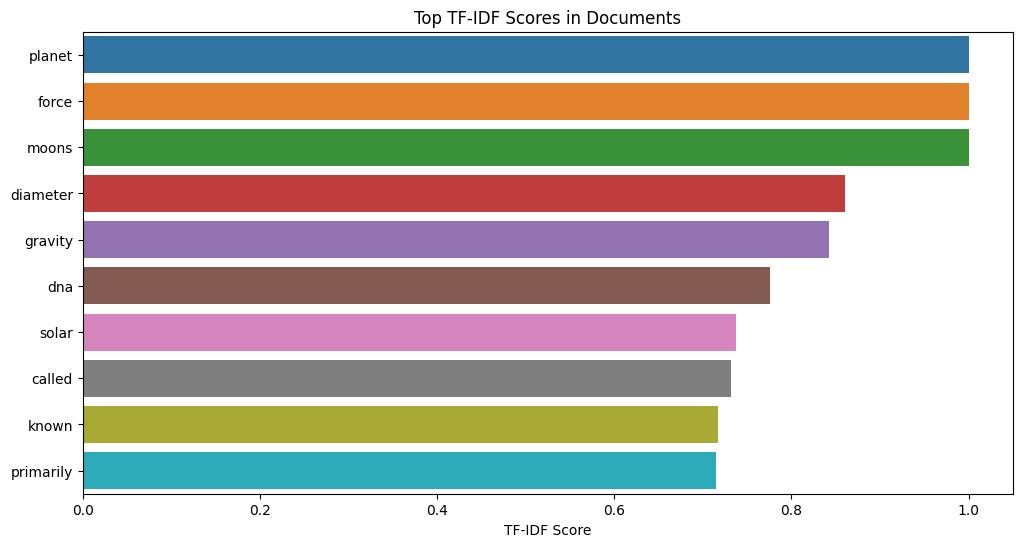

In [ ]:
# Visualizing the TF-IDF of the top 10 words
top_n_tfidf = tfidf_df.max().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_tfidf.values, y=top_n_tfidf.index)
plt.title('Top TF-IDF Scores in Documents')
plt.xlabel('TF-IDF Score')
plt.show()

In [ ]:
import random

for i in range(5):
    random_index = random.randint(0, len(dataframe) - 1)
    random_row = dataframe.iloc[random_index]
    prompt = random_row["question"] + " ->"
    actual_answer = random_row["answer"]


    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    response = model.generate(input_ids=input_ids, max_length=20)[0]

    response_text = tokenizer.decode(response, skip_special_tokens=True)

    print('*************************************')
    print('Question: ', prompt)
    print('Actual Answer:', actual_answer)
    print('Bot Answer: ', response_text)
    print('*************************************\n')

*************************************
Question:  What impact did the Plessy v. Ferguson Supreme Court decision have on segregation? ->
Actual Answer: Correct Answer- It upheld the 'separate but equal' doctrine and reinforced racial segregation.

Rationale- The decision supported segregation and allowed the 'separate but equal' policy to continue.

Distractor 1- It declared segregation unconstitutional and ended racial discrimination.
Distractor 2- It encouraged integration and equal treatment.
Distractor 3- It had no impact on racial segregation.
Bot Answer:  The Supreme Court decision has largely halted segregation in the United States.
*************************************

*************************************
Question:  Why do many of the gases in Mercury's atmosphere escape into space? ->
Actual Answer: Correct Answer- The planet's weak gravity.

Rationale- Mercury's weak gravity cannot hold onto the gases, leading to their escape.

Distractor 1- Solar winds.
Distractor 2- Intense